In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Implement ML functions

In [3]:
def compute_cost(y, tx, w):
    return compute_cost_MSE(y,tx,w)
    
def compute_cost_MSE(y,tx,w):
    e=y-(tx @ w)
    return (1/(2*y.shape[0]))*(e.T @ e)
def compute_cost_MAE(y,tx,w):
    e=y-(tx @ w)
    return (1/y.shape[0])*np.absolute(e).sum()

In [4]:
def compute_gradient_MSE(y,tx,w):
    """Compute the gradient."""
    e=y-(tx @ w)
    return -1/y.shape[0]*(tx.T @ e)

In [5]:
def general_gradient_descent(y, tx, initial_w, max_iters, gamma, grad_function, cost_function):
    """Gradient descent algorithm who work with arbitrary gradient and cost function
    grad and cost function should take y,tw and w as parameter and return resêctivly the gradient vector and the scalar error"""
    # Define parameters to store w and loss
    ws = [initial_w.ravel()]
    losses = []
    w = initial_w.ravel()
    for n_iter in range(max_iters):
        #compute gradient and loss
        gradient=grad_function(y,tx,w)
        loss=cost_function(y,tx,w)
        if n_iter % 50 == 0:
            print("Current iteration={i}, the loss={l}".format(i=n_iter, l=loss))
        #update w by gradient
        w=w-gamma*gradient
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
        #     bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses[-1], ws[-1]

In [6]:
def general_stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma, stock_grad_function, cost_function):
    """Gradient descent algorithm who work with arbitrary gradient and cost function
    grad and cost function should take y,tw and w as parameter and return respectivly the gradient vector and the scalar error"""
    
    # implement stochastic gradient descent.
    ws = [initial_w.ravel()]
    losses = []
    w = initial_w.ravel()
    
    minibatchs = batch_iter(y, tx, batch_size, num_batches=math.floor(y.shape[0]/batch_size))
    for n_iter in range(0,max_epochs):
        
        # compute gradient and loss
        minibatch=minibatchs.__next__()
        gradient=stock_grad_function(minibatch[0],minibatch[1],w)
        loss=cost_function(y,tx,w)
        
        # update w by gradient
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses[-1], ws[-1]

In [7]:
def least_squares_GD(y, tx, gamma, max_iters):
    return general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)).ravel(),max_iters,gamma,compute_gradient_MSE,compute_cost_MSE)

#general_gradient_descent(y,tX,np.zeros((tX.shape[1], 1)),20,0.000003,compute_gradient_MSE,compute_cost_MSE)


In [8]:
def least_squares_SGD(y, tx, gamma, max_iters):
    batch_size = y.shape[0]//2
    return general_stochastic_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),batch_size,max_iters,gamma,compute_gradient_MSE,compute_cost_MSE)

In [9]:
def least_squares(y, tx):
    w = np.linalg.solve(tx.T.dot(tx),tx.T.dot(y)) #return best weight
    return compute_cost_MSE(y, tx, w), w

In [10]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    
    lambp = lamb*(2*tx.shape[0])
    #return np.linalg.inv(tx.T.dot(tx)+lambp*np.eye(tx.shape[1])).dot(tx.T).dot(y)
    w =  np.linalg.solve(tx.T.dot(tx)+lambp*np.eye(tx.shape[1]),tx.T.dot(y))
    return compute_cost_MSE(y, tx, w), w

### Logistic

In [11]:
def sigmoid(t):
    """apply sigmoid function on t."""
    z = np.exp(t)
    return z/(1+z)

def compute_loss_logistic(y, tx, w, lambda_=0):
    """compute the cost by negative log likelihood."""
    clip = np.clip(tx @ w, -700, 700)
    if lambda_ == 0:
        return (1/y.shape[0])*np.sum(np.log(1+np.exp(clip))-y*(tx @ w))
    else:
        return (1/y.shape[0])*np.sum(np.log(1+np.exp(clip))-y*(tx @ w)) + lambda_*np.sum(w*w) #or + lambda_*w.T*w
    #return -np.sum(np.log(1+np.exp(tx @ w))-y*(tx @ w))
    
def compute_gradient_sigmoid(y, tx, w, lambda_=0):
    """compute the gradient of loss."""
    clip = np.clip(tx @ w, -700, 700)
    if lambda_ == 0:
        return (1/y.shape[0])*tx.T.dot(sigmoid(clip)-y)
    else:
        return (1/y.shape[0])*tx.T.dot(sigmoid(clip)-y) + lambda_*2*w

In [12]:
def logistic_regression(y, tx, gamma ,max_iters):
    print("fuck")
    ok = general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),max_iters,gamma,compute_gradient_sigmoid,compute_loss_logistic)
    return ok

In [13]:
def reg_logistic_regression(y, tx, lambda_ , gamma, max_iters):
    gradf = partial(compute_gradient_sigmoid,lambda_ = lambda_)
    costf = partial(compute_loss_logistic, lambda_ = lambda_)
    return general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),max_iters,gamma,gradf,costf)


### Cross-validation

In [14]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tx, function_to_test,k_fold, lambda_,seed,cost_function):
    """return the loss of train values, loss of test values and weights"""
    k_indices=build_k_indices(y,k_fold,seed)
    loss_tr=[]
    loss_te=[]
    weights=[]
    for k in range(k_indices.shape[0]):
        # get k'th subgroup in test, others in train:
        train_indices=k_indices[[i for i in range(len(k_indices)) if i != k]]
        train_tx,train_y=tx[np.ravel(train_indices)],y[np.ravel(train_indices)]
        test_tx,test_y=tx[k_indices[k]],y[k_indices[k]]

        loss_tr_k, weight_k = function_to_test(train_y, train_tx,lambda_)
        loss_tr.append(loss_tr_k)
        weights.append(weight_k)
        loss_te.append(cost_function(test_y,test_tx,weight_k))
    return np.mean(loss_tr), np.mean(loss_te),np.mean(weights,axis=0)

def finding_lambda(y, tx, function_to_test,k_fold,seed,lambdas,cost_function):
    
    # define lists to store the loss of training data and test data
    loss_tr = []
    loss_te = []
    for lambda_ in lambdas:
        print("lambda : ", lambda_)
        if(cost_function==compute_loss_logistic):
            cost_function=partial(compute_loss_logistic,lambda_=lambda_)
        loss_tr_lamb,loss_te_lamb,weight_lamb=cross_validation(y,tx,function_to_test,k_fold,lambda_,seed,cost_function)
        loss_tr.append(loss_tr_lamb)
        loss_te.append(loss_te_lamb)
    return loss_tr,loss_te
        



## Preprocessing data formating

In [15]:
def remove_outliers(tX,mean_x,std_x):
    tX2=tX.copy()
    for sample in range(tX.shape[0]):
        for dim in range(tX.shape[1]):
            if(tX2[sample,dim]>mean_x[dim]+2*std_x[dim]):
                tX2[sample,dim]=mean_x[dim]
            if(tX2[sample,dim]<mean_x[dim]-2*std_x[dim]):
                tX2[sample,dim]=mean_x[dim]
            if(tX2[sample,dim]==-999):
                tX2[sample,dim]=0
    return tX2
def modify_y(y):
    y2 = y.copy()
    y2[np.where(y==-1)] = 0
    return y2

In [54]:
def rescale(tx):
    mins = np.amin(tx,axis = 0)
    maxs = np.amax(tx,axis = 0)
    txscale = (tx-mins)/(maxs-mins)
    return txscale

In [55]:
mean_x = np.mean(tX, axis=0)
std_x = np.std(tX, axis=0)
tX_norm=remove_outliers(tX,mean_x,std_x)
y0=modify_y(y)
print(tX_norm)

[[ 138.47         51.655        97.827      ...,    1.24         -2.475
   113.497     ]
 [ 160.937        68.768       103.235      ...,    0.            0.
    46.226     ]
 [ -49.02307944   49.23981928  125.953      ...,    0.            0.
    44.251     ]
 ..., 
 [ 105.457        60.526        75.839      ...,    0.            0.
    41.992     ]
 [  94.951        19.362        68.812      ...,    0.            0.            0.        ]
 [ -49.02307944   72.756        70.831      ...,    0.            0.            0.        ]]


In [20]:
tX_norm = rescale(tX)

## Prediction Formula

#### Finding a good lambda for ridge regression

lambda :  0.0001
lambda :  0.000161026202756
lambda :  0.00025929437974
lambda :  0.000417531893656
lambda :  0.00067233575365
lambda :  0.00108263673387
lambda :  0.0017433288222
lambda :  0.00280721620394
lambda :  0.00452035365636
lambda :  0.00727895384398
lambda :  0.0117210229753
lambda :  0.0188739182214
lambda :  0.0303919538231
lambda :  0.0489390091848
lambda :  0.0788046281567
lambda :  0.126896100317
lambda :  0.204335971786
lambda :  0.329034456231
lambda :  0.529831690628
lambda :  0.853167852417
lambda :  1.37382379588
lambda :  2.21221629107
lambda :  3.56224789026
lambda :  5.73615251045
lambda :  9.23670857187
lambda :  14.8735210729
lambda :  23.9502661999
lambda :  38.5662042116
lambda :  62.1016941892
lambda :  100.0


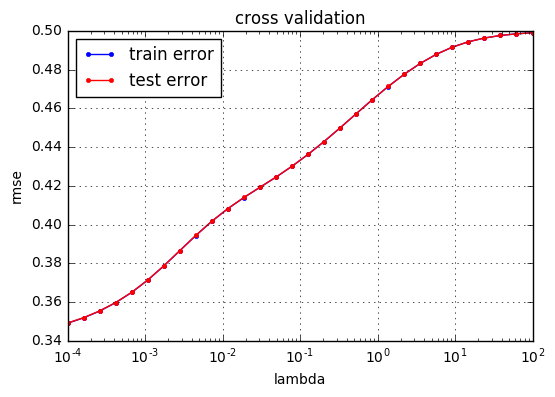

In [21]:
initial_w=np.zeros(tX.shape[1])
function_to_test=ridge_regression
k_fold=4
lambdas = np.logspace(-4, 2, 30)
loss_tr,loss_te=finding_lambda(y,tX_norm,function_to_test,k_fold,1,lambdas,compute_cost)
from helpers import *
cross_validation_visualization(lambdas, loss_tr, loss_te)

In [ ]:
loss_tr,loss_te,w=cross_validation(y, tX_norm, ridge_regression,4, 0,1,compute_cost)
loss_tr,loss_te,w

#### Finding a good lambda for penalized logistic regression

lambda :  0.0001
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
lambda :  0.000161026202756
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
lambda :  0.00025929437974
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
lambda :  0.000417531893656
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.6931471805599453
lambda :  0.00067233575365
Current iteration=0, the loss=0.6931471805599453
Current iteration=0, the loss=0.69314718

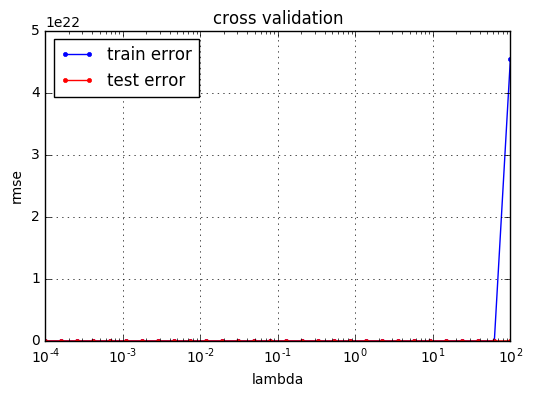

In [23]:
initial_w=np.zeros(tX.shape[1])
gamma=0.03#0.00003
max_iters=20
function_to_test=partial(reg_logistic_regression,gamma=gamma, max_iters=max_iters)
k_fold=4
lambdas = np.logspace(-4, 2, 30)
loss_tr,loss_te=finding_lambda(y0,tX_norm,function_to_test,k_fold,1,lambdas,compute_loss_logistic)
from helpers import *
cross_validation_visualization(lambdas, loss_tr, loss_te)

#### Logistic regression

In [ ]:
tXs = rescale(tX)
tX_norm = tXs
y0=modify_y(y)
loss_tr,weights=logistic_regression(y0,tX_norm,0.03,800)

In [ ]:
loss_tr,weights=logistic_regression(y0,tX_norm,0.00003,800)

In [ ]:
y_pred2 = np.dot(tX_norm, weights)
y_pred2[np.where(y_pred2 <= 1/2)] = -1
y_pred2[np.where(y_pred2 > 1/2)] = 1
len((y-y_pred2)[np.where(y-y_pred2!=0)])

In [ ]:
len(y)

In [ ]:
loss, weights=least_squares_GD(y,tX_norm,0.000003,1000)

In [35]:
# losss,weights = least_squares(y,tX)
loss,weights = least_squares(y,tX_norm)

In [29]:
print(losss,weights)

0.339686809477 [  8.03494352e-05  -7.20202266e-03  -6.05417274e-03  -5.47559078e-04
  -1.93874687e-02   4.73451613e-04  -2.60379058e-02   3.25106299e-01
  -3.80780000e-05  -2.72788699e+00  -2.21220141e-01   9.50794097e-02
   6.40351609e-02   2.73614667e+00  -3.31801090e-04  -9.54325141e-04
   2.74090341e+00  -5.34165279e-04   9.73498912e-04   3.69225050e-03
   3.54487164e-04  -5.43344618e-04  -3.30448035e-01  -1.40800497e-03
   8.31432840e-04   1.02117276e-03  -1.68047418e-03  -5.83664793e-03
  -1.11088004e-02   2.72834692e+00]


In [37]:
y_pred = np.dot(tX_norm, weights)
print(y_pred)
y_pred[np.where(y_pred <= 0)] = -1
print(y_pred)
y_pred[np.where(y_pred > 0)] = 1
print(y_pred)
print(y)
print (len((y_pred-y)[np.where((y_pred-y)!=0)]))

[-0.13863766  0.01615254 -0.59610159 ..., -0.34290224  0.13219625
 -0.64552817]
[-1.          0.01615254 -1.         ..., -1.          0.13219625 -1.        ]
[-1.  1. -1. ..., -1.  1. -1.]
[ 1. -1. -1. ...,  1. -1. -1.]
63771


In [ ]:
loss,w = logistic_regression(y,tXs,0.03,20)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
def predict_labels_modified_y(weights, data):
    """Generates class predictions given weights, and a test data matrix when y was 0 or 1 for the weights"""
    y_pred = np.dot(data, weights)*2-1
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    
    return y_pred

In [ ]:
tX_test_norm=remove_outliers(tX_test,mean_x,std_x)

In [ ]:
OUTPUT_PATH = '../submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test_norm)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [76]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [77]:
DATA_TEST_PATH = '../test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [81]:
loss,weights = least_squares(y,tX)

In [83]:
y_pred = np.dot(tX, weights)
print(y_pred)
y_pred[np.where(y_pred <= 0)] = -1
print(y_pred)
y_pred[np.where(y_pred > 0)] = 1
print(y_pred)
print(y)
print (len((y_pred-y)[np.where((y_pred-y)!=0)]))

[-0.1034803   0.0132493  -0.62990433 ..., -0.34063008  0.12640066
 -0.65262579]
[-1.          0.0132493  -1.         ..., -1.          0.12640066 -1.        ]
[-1.  1. -1. ..., -1.  1. -1.]
[ 1. -1. -1. ...,  1. -1. -1.]
63918


In [80]:
OUTPUT_PATH = '../submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)